# Exploring Dandiset 000945: Neural Spiking Data in Rat Somatosensory Cortex Responding to Transcranial Focused Ultrasound Stimulation

**IMPORTANT NOTICE**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results and verify them independently.

## Overview
This dataset contains neural spiking data recorded from the somatosensory cortex of awake head-fixed rats while they received transcranial focused ultrasound (tFUS) stimulation. The recordings were made using 32-channel NeuroNexus electrodes chronically implanted in the rat brain. 

The dataset includes recordings with different pulse repetition frequencies (PRFs): 30 Hz, 300 Hz, 1500 Hz, 3000 Hz, and 4500 Hz. Each recording contains 500 trials of ultrasound stimulation delivered every ~2.5 seconds with 10% jitter. Each ultrasound stimulation used a 200 microsecond pulse duration and 67 ms ultrasound duration.

This notebook will explore neural responses to the ultrasound stimulation, analyze differences between cell types, and examine how PRF affects neural activity.

## Required Packages

This notebook uses the following packages:
- pynwb: For reading NWB files
- h5py: For working with HDF5 files
- remfile: For remote file access
- numpy: For numerical operations
- matplotlib: For plotting
- pandas: For data manipulation
- scipy: For statistical analyses
- seaborn: For enhanced visualization

In [1]:
import pynwb
import h5py
import remfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

# Set the plotting style
sns.set_theme()

## Loading Data from DANDI Archive

First, we'll connect to the DANDI archive and access Dandiset 000945. We'll look at the available assets (NWB files) in the dataset.

In [2]:
from dandi.dandiapi import DandiAPIClient

# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("000945")
assets = list(dandiset.get_assets())

print(f"Found {len(assets)} assets in the dataset")
print("\nFirst 5 assets:")
for asset in assets[:5]:
    print(f"- {asset.path}")

Found 75 assets in the dataset

First 5 assets:
- sub-BH498/sub-BH498_ses-20240306T124227_ecephys.nwb
- sub-BH498/sub-BH498_ses-20240305T200606_ecephys.nwb
- sub-BH498/sub-BH498_ses-20240305T191833_ecephys.nwb
- sub-BH498/sub-BH498_ses-20230906T180913_ecephys.nwb
- sub-BH498/sub-BH498_ses-20240305T204552_ecephys.nwb


The dataset contains multiple files from several rat subjects, with each file corresponding to a different PRF setting. 

Let's examine one of the NWB files in more detail. We'll start by loading a file with 3000 Hz PRF from subject BH497.

In [3]:
# Define the URL for the specific asset we want to examine
url = "https://api.dandiarchive.org/api/assets/a4e04662-e4cb-49f3-9076-41e04e833a11/download/"

# Load the NWB file using remfile for remote access
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

print("NWB File Information:")
print(f"Subject: {nwb.subject.subject_id}")
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Species: {nwb.subject.species}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")

NWB File Information:
Subject: BH497
Session Description: Awake S1 Stimulation by tFUS
Identifier: BH498_3000_200_anes
Species: Rattus norvegicus
Age: P24W
Sex: M


/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Exploring the Electrode and Unit Information

Let's examine the electrode setup and the recorded units (neurons).

In [4]:
# Examine the electrode information
electrodes_df = nwb.electrodes.to_dataframe()
print(f"Number of electrodes: {len(electrodes_df)}")
print("\nElectrode information:")
print(electrodes_df[['x', 'y', 'z', 'imp', 'location', 'group_name']].head())

# Examine the units information
units_df = nwb.units.to_dataframe()
print(f"\nNumber of units: {len(units_df)}")

# Count by cell type
print("\nUnits by cell type:")
print(units_df['celltype_label'].value_counts())

Number of electrodes: 32

Electrode information:
      x     y    z  imp location   group_name
id                                           
0   1.0  10.0  0.0  NaN  unknown  shank1elec1
1   1.0  11.0  0.0  NaN  unknown  shank1elec2
2   1.0   9.0  0.0  NaN  unknown  shank1elec3
3   1.0   8.0  0.0  NaN  unknown  shank1elec4
4   1.0   7.0  0.0  NaN  unknown  shank1elec5



Number of units: 64

Units by cell type:
celltype_label
2.0    32
1.0    32
Name: count, dtype: int64


## Examining Trial Structure

Now, let's look at the experimental trial structure. In this experiment, ultrasound stimulation was delivered approximately every 2.5 seconds (with 10% jitter) for a total of 500 trials.

Number of trials: 500

First 5 trials:
    start_time  stop_time
id                       
1     0.408248   2.608248
2     3.050619   5.250619
3     5.559296   7.759296
4     8.108483  10.308483
5    10.392863  12.592863

Trial statistics:
Mean trial duration: 2.200 seconds
Mean inter-trial interval: 0.300 seconds


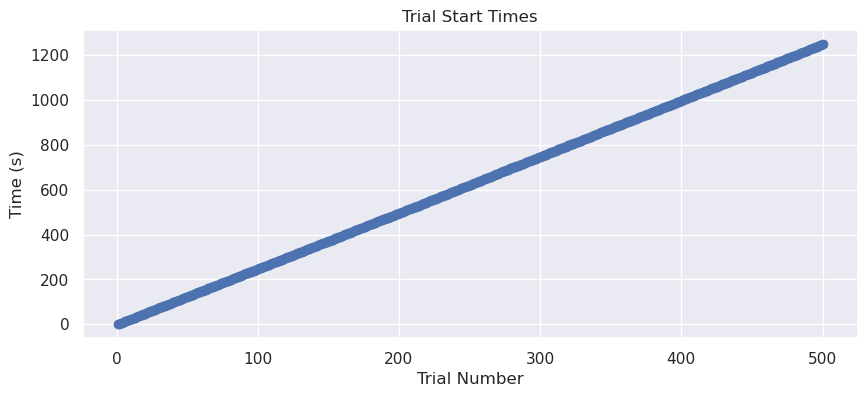

In [5]:
# Get trial information
trials_df = nwb.trials.to_dataframe()
print(f"Number of trials: {len(trials_df)}")
print("\nFirst 5 trials:")
print(trials_df.head())

# Calculate trial durations and inter-trial intervals
trials_df['duration'] = trials_df['stop_time'] - trials_df['start_time']
trials_df['iti'] = trials_df['start_time'].shift(-1) - trials_df['stop_time']

print("\nTrial statistics:")
print(f"Mean trial duration: {trials_df['duration'].mean():.3f} seconds")
print(f"Mean inter-trial interval: {trials_df['iti'].dropna().mean():.3f} seconds")

# Plot trial start times
plt.figure(figsize=(10, 4))
plt.plot(trials_df.index, trials_df['start_time'], 'o-')
plt.title('Trial Start Times')
plt.xlabel('Trial Number')
plt.ylabel('Time (s)')
plt.grid(True)
plt.show()

The timing of trials shows a consistent pattern with small jitter as described in the dataset. The mean trial duration is approximately 2.2 seconds, and the mean inter-trial interval is around 0.3 seconds.

## Analyzing Neural Activity

Next, let's analyze the neural activity in this recording. First, we'll look at the spike counts across different units.

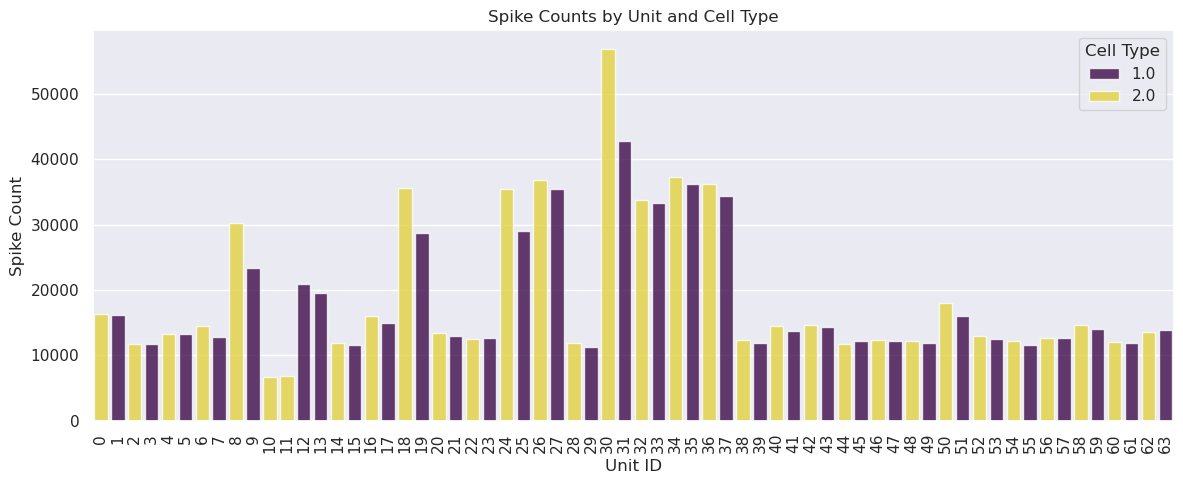

Average spike counts by cell type:
           count         mean      min      max
cell_type                                      
1.0         32.0  18422.18750  11287.0  42711.0
2.0         32.0  19107.28125   6615.0  56864.0


In [6]:
# Calculate spike counts for each unit
spike_counts = []
for i, row in units_df.iterrows():
    spike_counts.append(len(row['spike_times']))

# Create a DataFrame with unit IDs, cell types, and spike counts
unit_summary = pd.DataFrame({
    'unit_id': units_df.index,
    'cell_type': units_df['celltype_label'],
    'spike_count': spike_counts
})

# Plot spike counts
plt.figure(figsize=(12, 5))
sns.barplot(x='unit_id', y='spike_count', hue='cell_type', data=unit_summary,
            palette='viridis', alpha=0.8)
plt.title('Spike Counts by Unit and Cell Type')
plt.xlabel('Unit ID')
plt.ylabel('Spike Count')
plt.xticks(rotation=90)
plt.legend(title='Cell Type')
plt.tight_layout()
plt.show()

# Calculate average spike count by cell type
print("Average spike counts by cell type:")
print(unit_summary.groupby('cell_type')['spike_count'].describe()[['count', 'mean', 'min', 'max']])

We can see that there's considerable variability in spike counts across units, with some units firing many more spikes than others. Let's examine the spike timing patterns of a few example units.

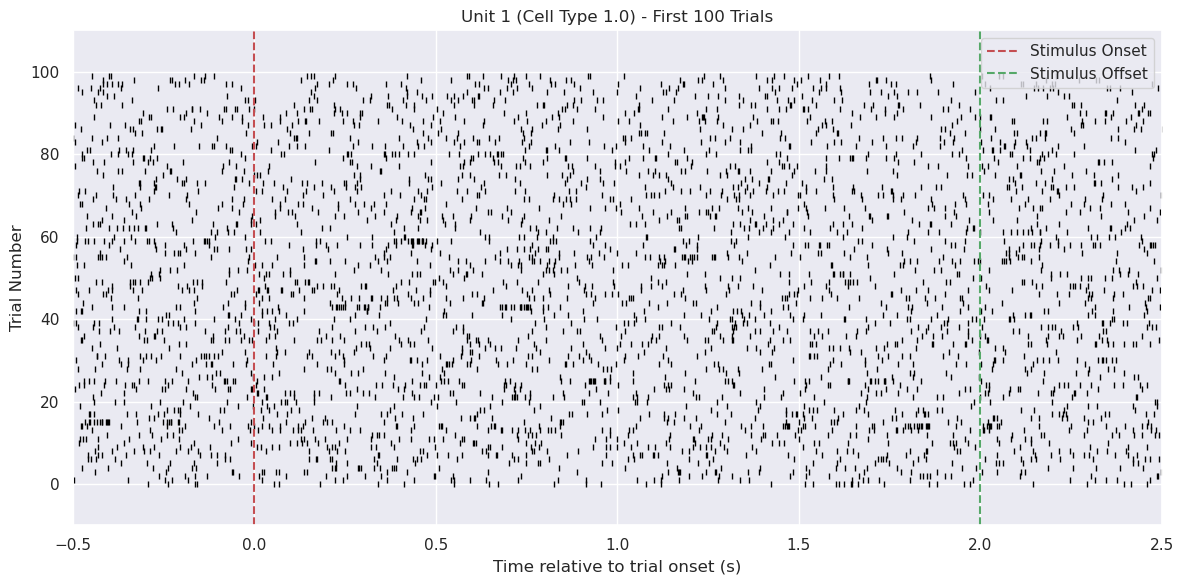

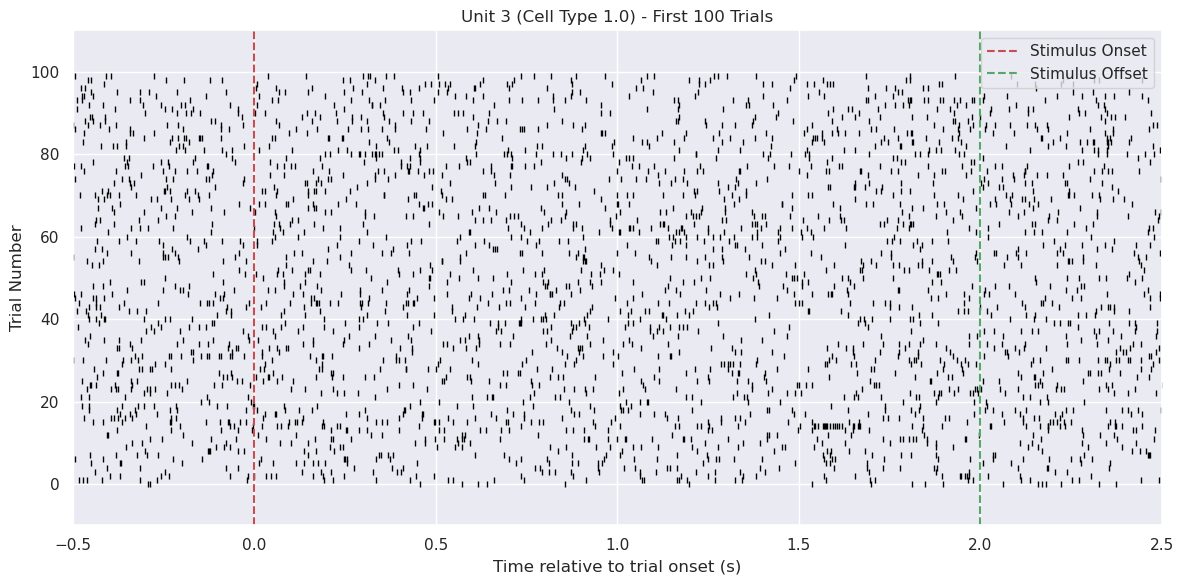

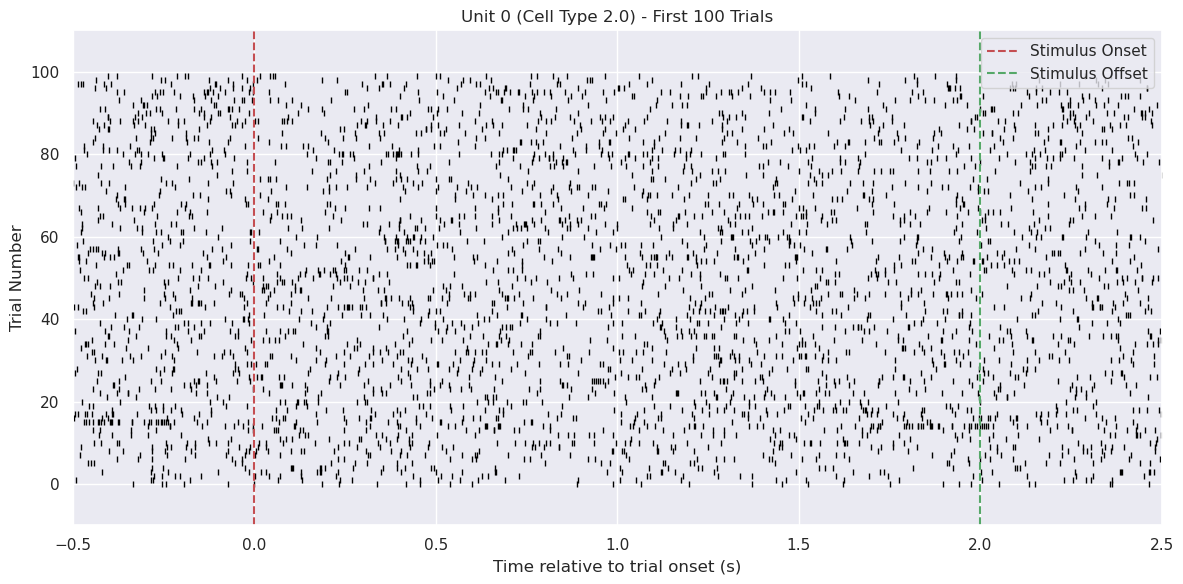

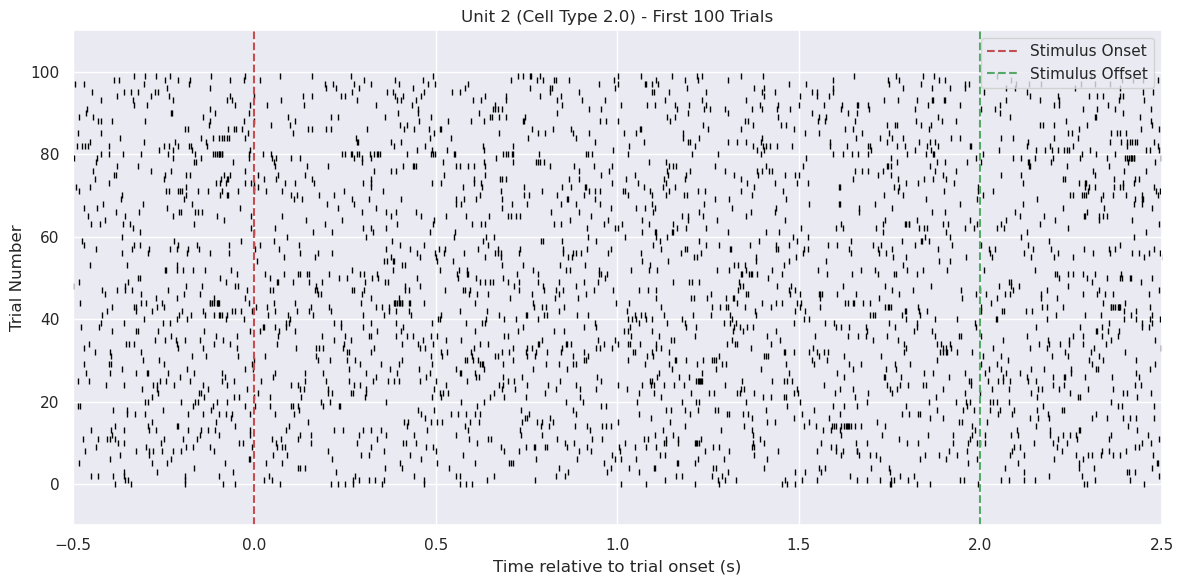

In [7]:
# Define a function to create a raster plot for a single unit
def plot_unit_raster(spike_times, trial_starts, pre_time=0.5, post_time=2.5, title="Unit Raster"):
    plt.figure(figsize=(12, 6))
    
    # Create trial-aligned spikes
    for i, trial_start in enumerate(trial_starts):
        # Find spikes in the window around this trial
        window_start = trial_start - pre_time
        window_end = trial_start + post_time
        
        # Convert to trial-relative time
        trial_spikes = spike_times[(spike_times >= window_start) & (spike_times < window_end)] - trial_start
        
        # Plot spikes as dots
        plt.plot(trial_spikes, np.ones_like(trial_spikes) * i, '|', color='black', markersize=4)
    
    plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
    plt.axvline(x=2.0, color='g', linestyle='--', label='Stimulus Offset')
    plt.title(title)
    plt.xlabel('Time relative to trial onset (s)')
    plt.ylabel('Trial Number')
    plt.xlim(-pre_time, post_time)
    plt.ylim(-10, len(trial_starts) + 10)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Get trial start times
trial_starts = trials_df['start_time'].values

# Select 2 units of each cell type to examine
cell_type_1_units = units_df[units_df['celltype_label'] == 1.0].iloc[:2]
cell_type_2_units = units_df[units_df['celltype_label'] == 2.0].iloc[:2]

# Plot rasters for Cell Type 1 units
for idx, row in cell_type_1_units.iterrows():
    plot_unit_raster(row['spike_times'], trial_starts[:100], 
                    title=f"Unit {idx} (Cell Type 1.0) - First 100 Trials")

# Plot rasters for Cell Type 2 units
for idx, row in cell_type_2_units.iterrows():
    plot_unit_raster(row['spike_times'], trial_starts[:100], 
                    title=f"Unit {idx} (Cell Type 2.0) - First 100 Trials")

The raster plots show the spiking activity of individual neurons across trials. Each horizontal line represents a trial, and each vertical line marks a spike time. The red dashed line indicates stimulus onset, and the green dashed line indicates stimulus offset.

## Analyzing Neural Responses to Stimulation

Now, let's analyze how neurons respond to the ultrasound stimulation. We'll create Peri-Stimulus Time Histograms (PSTHs) to visualize the changes in firing rate around the stimulus.

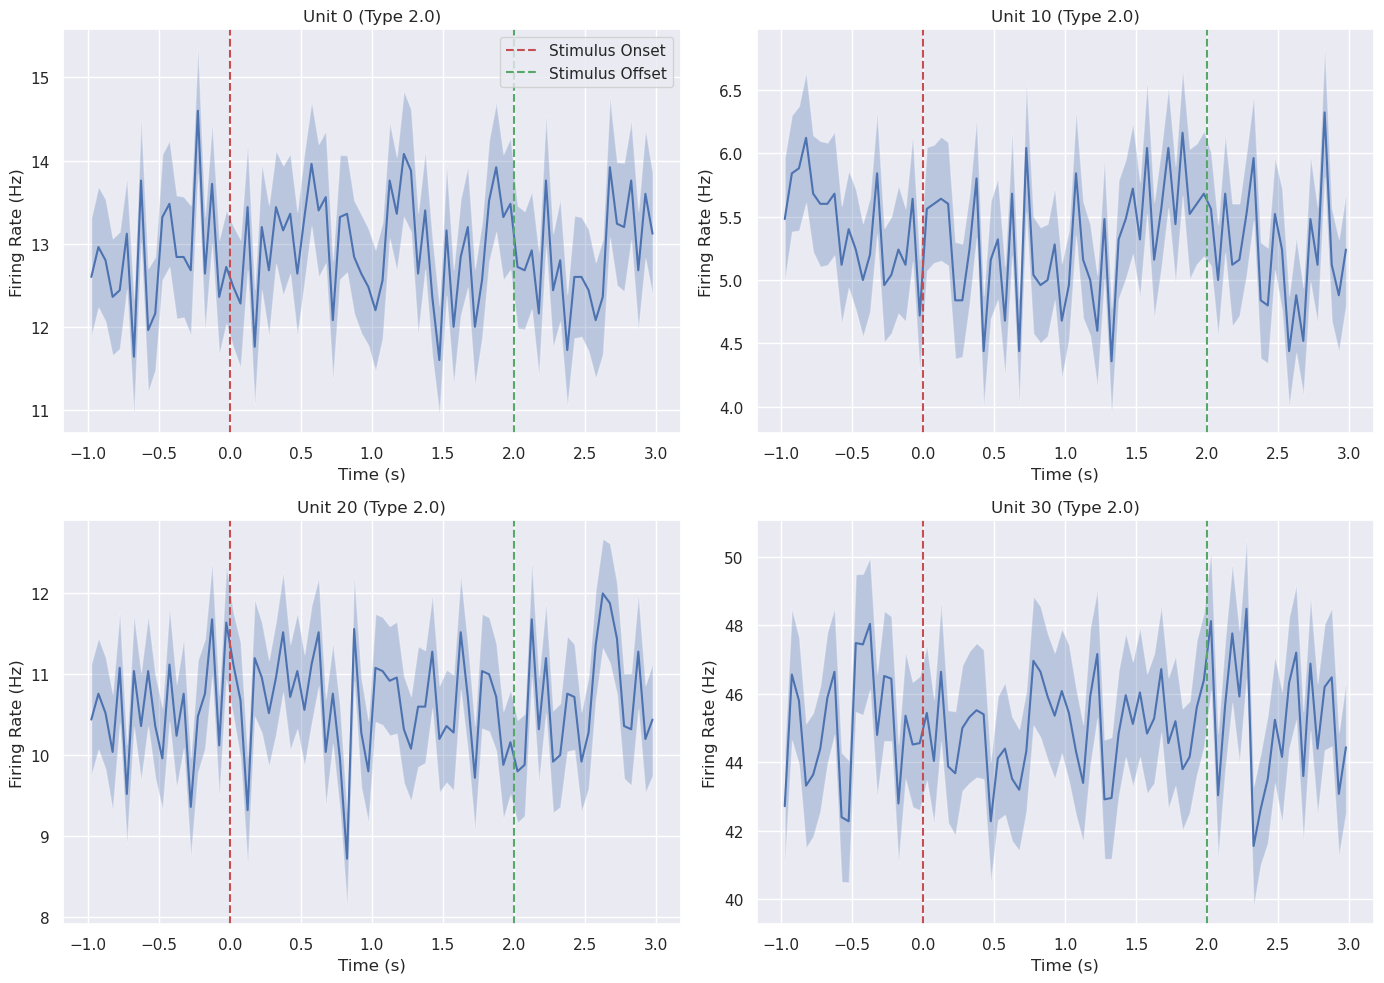

In [8]:
# Function to compute PSTH for one unit
def compute_psth(spike_times, trial_times, pre_time=1.0, post_time=3.0, bin_size=0.05):
    n_trials = len(trial_times)
    n_bins = int((pre_time + post_time) / bin_size)
    psth = np.zeros((n_trials, n_bins))
    
    for i, trial_start in enumerate(trial_times):
        # Find spikes in the window around this trial
        window_start = trial_start - pre_time
        window_end = trial_start + post_time
        
        # Convert to trial-relative time
        trial_spikes = spike_times[(spike_times >= window_start) & (spike_times < window_end)] - trial_start
        
        # Bin the spikes
        hist, _ = np.histogram(trial_spikes, bins=np.linspace(-pre_time, post_time, n_bins + 1))
        psth[i, :] = hist
    
    # Average across trials and convert to firing rate
    mean_psth = np.mean(psth, axis=0) / bin_size  # Convert to spikes/second
    sem_psth = stats.sem(psth, axis=0) / bin_size
    
    return mean_psth, sem_psth

# Define parameters for PSTH
pre_time = 1.0  # Time before stimulus onset (seconds)
post_time = 3.0  # Time after stimulus onset (seconds)
bin_size = 0.05  # Bin size for PSTH (seconds)
n_bins = int((pre_time + post_time) / bin_size)
time_bins = np.linspace(-pre_time, post_time, n_bins + 1)
time_centers = (time_bins[:-1] + time_bins[1:]) / 2

# Compute PSTHs for a few example units
example_units = [units_df.iloc[0], units_df.iloc[10], units_df.iloc[20], units_df.iloc[30]]

plt.figure(figsize=(14, 10))
for i, unit in enumerate(example_units):
    unit_id = unit.name
    spike_times = unit['spike_times']
    cell_type = unit['celltype_label']
    
    # Compute PSTH
    mean_psth, sem_psth = compute_psth(spike_times, trial_starts, pre_time, post_time, bin_size)
    
    # Plot PSTH
    plt.subplot(2, 2, i+1)
    plt.fill_between(time_centers, mean_psth - sem_psth, mean_psth + sem_psth, alpha=0.3)
    plt.plot(time_centers, mean_psth)
    plt.axvline(x=0, linestyle='--', color='r', label='Stimulus Onset')
    plt.axvline(x=2.0, linestyle='--', color='g', label='Stimulus Offset')
    plt.title(f'Unit {unit_id} (Type {cell_type})')
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
    if i == 0:
        plt.legend(loc='upper right')
    plt.grid(True)

plt.tight_layout()
plt.show()

The PSTHs show the average firing rate of neurons around the time of stimulus presentation. Some units show changes in firing rate in response to the stimulus onset or offset, while others show less pronounced responses.

## Comparing Different PRFs

Now, let's load data from another recording with a different PRF (1500 Hz) and compare neural responses.

In [9]:
# Load data from a recording with 1500 Hz PRF
url_1500hz = "https://api.dandiarchive.org/api/assets/526c681d-0c50-44e1-92be-9c0134c71fd8/download/"
remote_file_1500 = remfile.File(url_1500hz)
h5_file_1500 = h5py.File(remote_file_1500)
io_1500 = pynwb.NWBHDF5IO(file=h5_file_1500)
nwb_1500 = io_1500.read()

print("1500 Hz PRF Recording Information:")
print(f"Identifier: {nwb_1500.identifier}")

# Get trials and units data
trials_1500 = nwb_1500.trials.to_dataframe()
units_1500 = nwb_1500.units.to_dataframe()
trial_starts_1500 = trials_1500['start_time'].values

# Rename our original variables to clarify PRF
trials_3000 = trials_df
units_3000 = units_df
trial_starts_3000 = trial_starts

print(f"Comparing: {len(units_3000)} units in 3000 Hz recording vs {len(units_1500)} units in 1500 Hz recording")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.5.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


1500 Hz PRF Recording Information:
Identifier: BH498_1500_200_anes


Comparing: 64 units in 3000 Hz recording vs 64 units in 1500 Hz recording


Now let's compare the neural responses between the two PRFs for the different cell types.

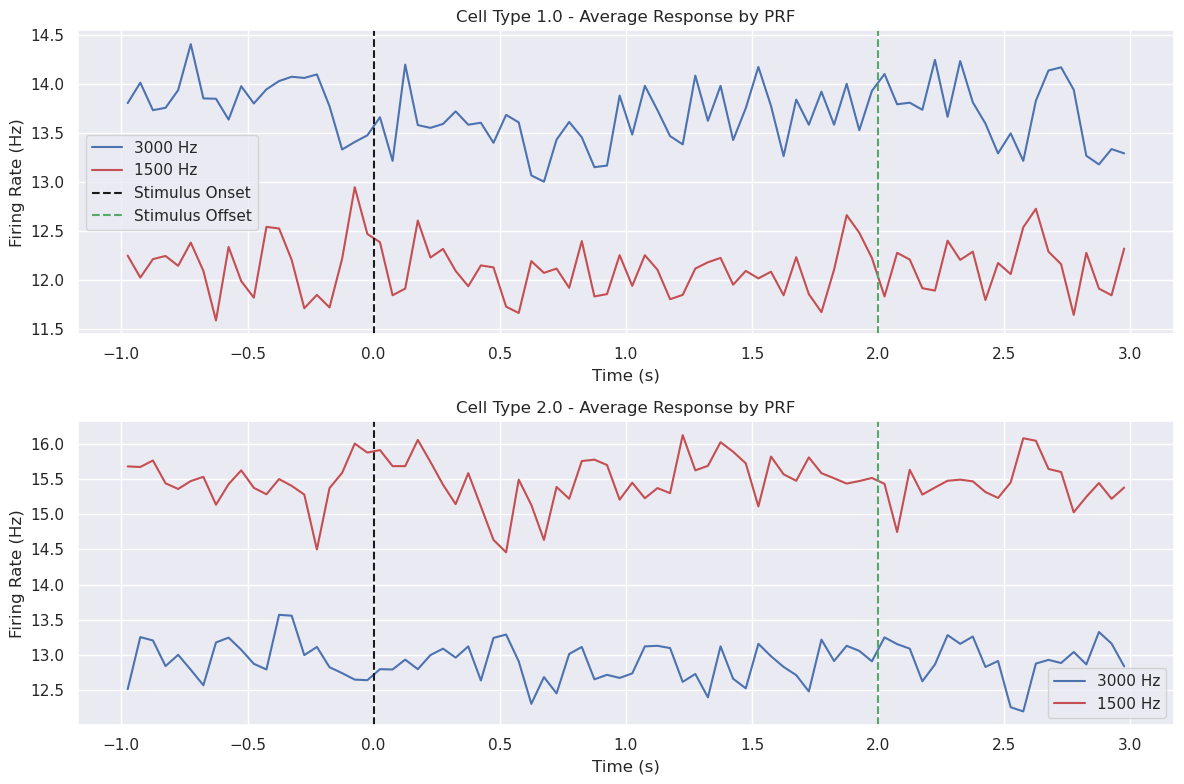

In [10]:
# Compute average PSTHs for each cell type and PRF
cell_types = [1.0, 2.0]

# Limit to first 20 units of each cell type for faster computation
units_3000_type1 = units_3000[units_3000['celltype_label'] == 1.0].iloc[:10]
units_3000_type2 = units_3000[units_3000['celltype_label'] == 2.0].iloc[:10]
units_1500_type1 = units_1500[units_1500['celltype_label'] == 1.0].iloc[:10]
units_1500_type2 = units_1500[units_1500['celltype_label'] == 2.0].iloc[:10]

# Compute PSTHs
psths_3000_type1 = []
psths_3000_type2 = []
psths_1500_type1 = []
psths_1500_type2 = []

# Compute for 3000 Hz, Type 1
for _, unit in units_3000_type1.iterrows():
    mean_psth, _ = compute_psth(unit['spike_times'], trial_starts_3000, pre_time, post_time, bin_size)
    psths_3000_type1.append(mean_psth)

# Compute for 3000 Hz, Type 2
for _, unit in units_3000_type2.iterrows():
    mean_psth, _ = compute_psth(unit['spike_times'], trial_starts_3000, pre_time, post_time, bin_size)
    psths_3000_type2.append(mean_psth)

# Compute for 1500 Hz, Type 1
for _, unit in units_1500_type1.iterrows():
    mean_psth, _ = compute_psth(unit['spike_times'], trial_starts_1500, pre_time, post_time, bin_size)
    psths_1500_type1.append(mean_psth)

# Compute for 1500 Hz, Type 2
for _, unit in units_1500_type2.iterrows():
    mean_psth, _ = compute_psth(unit['spike_times'], trial_starts_1500, pre_time, post_time, bin_size)
    psths_1500_type2.append(mean_psth)

# Average over units
mean_psth_3000_type1 = np.mean(psths_3000_type1, axis=0) if psths_3000_type1 else np.zeros(n_bins)
mean_psth_3000_type2 = np.mean(psths_3000_type2, axis=0) if psths_3000_type2 else np.zeros(n_bins)
mean_psth_1500_type1 = np.mean(psths_1500_type1, axis=0) if psths_1500_type1 else np.zeros(n_bins)
mean_psth_1500_type2 = np.mean(psths_1500_type2, axis=0) if psths_1500_type2 else np.zeros(n_bins)

# Plot comparisons
plt.figure(figsize=(12, 8))

# Cell Type 1
plt.subplot(2, 1, 1)
plt.plot(time_centers, mean_psth_3000_type1, 'b-', label='3000 Hz')
plt.plot(time_centers, mean_psth_1500_type1, 'r-', label='1500 Hz')
plt.axvline(x=0, linestyle='--', color='k', label='Stimulus Onset')
plt.axvline(x=2.0, linestyle='--', color='g', label='Stimulus Offset')
plt.title('Cell Type 1.0 - Average Response by PRF')
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.grid(True)

# Cell Type 2
plt.subplot(2, 1, 2)
plt.plot(time_centers, mean_psth_3000_type2, 'b-', label='3000 Hz')
plt.plot(time_centers, mean_psth_1500_type2, 'r-', label='1500 Hz')
plt.axvline(x=0, linestyle='--', color='k')
plt.axvline(x=2.0, linestyle='--', color='g')
plt.title('Cell Type 2.0 - Average Response by PRF')
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Quantifying the Response to Stimulation

Let's quantify the neural responses to stimulation by comparing firing rates before and during stimulation, and see if there are differences between PRFs.

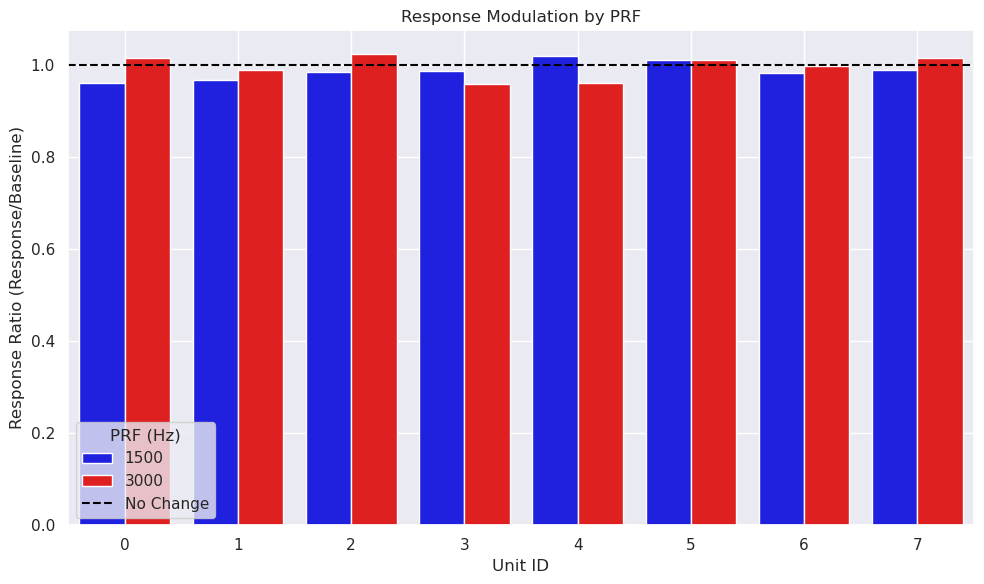

Response Statistics by Cell Type and PRF:
    prf cell_type response_ratio                  p_value
                            mean       std count <lambda>
0  1500       1.0       0.987737  0.018134     4        0
1  1500       2.0       0.985646  0.024414     4        0
2  3000       1.0       0.992551  0.025667     4        0
3  3000       2.0       0.999149  0.027668     4        0


In [11]:
# Define analysis windows
baseline_window = (-0.9, -0.1)  # 0.8s window before stimulus
response_window = (0.1, 0.9)    # 0.8s window during stimulus

def compute_response_metrics(spike_times, trial_times, baseline_window, response_window):
    """Compute baseline and response firing rates"""
    baseline_rates = []
    response_rates = []
    
    for trial_start in trial_times:
        # Find spikes in baseline window
        baseline_spikes = spike_times[(spike_times >= trial_start + baseline_window[0]) & 
                                      (spike_times < trial_start + baseline_window[1])]
        # Find spikes in response window
        response_spikes = spike_times[(spike_times >= trial_start + response_window[0]) & 
                                      (spike_times < trial_start + response_window[1])]
        
        baseline_duration = baseline_window[1] - baseline_window[0]
        response_duration = response_window[1] - response_window[0]
        
        baseline_rates.append(len(baseline_spikes) / baseline_duration)
        response_rates.append(len(response_spikes) / response_duration)
    
    mean_baseline = np.mean(baseline_rates)
    mean_response = np.mean(response_rates)
    
    # Statistical test
    t_stat, p_value = stats.ttest_rel(baseline_rates, response_rates)
    
    # Response ratio (response/baseline)
    response_ratio = mean_response / mean_baseline if mean_baseline > 0 else float('nan')
    
    return mean_baseline, mean_response, p_value, response_ratio

# Analyze a subset of units for each PRF and cell type
n_units_to_analyze = 8  # Limit to a small number for performance

# For 3000 Hz
results_3000 = []
for i in range(min(n_units_to_analyze, len(units_3000))):
    unit = units_3000.iloc[i]
    unit_id = unit.name
    spike_times = unit['spike_times']
    cell_type = unit['celltype_label']
    
    bl, resp, p, ratio = compute_response_metrics(
        spike_times, trial_starts_3000, baseline_window, response_window)
    
    results_3000.append({
        'unit_id': unit_id,
        'cell_type': cell_type, 
        'baseline': bl,
        'response': resp,
        'p_value': p,
        'response_ratio': ratio,
        'prf': 3000
    })

# For 1500 Hz
results_1500 = []
for i in range(min(n_units_to_analyze, len(units_1500))):
    unit = units_1500.iloc[i]
    unit_id = unit.name
    spike_times = unit['spike_times']
    cell_type = unit['celltype_label']
    
    bl, resp, p, ratio = compute_response_metrics(
        spike_times, trial_starts_1500, baseline_window, response_window)
    
    results_1500.append({
        'unit_id': unit_id,
        'cell_type': cell_type, 
        'baseline': bl,
        'response': resp,
        'p_value': p,
        'response_ratio': ratio,
        'prf': 1500
    })

# Combine results
all_results = pd.DataFrame(results_3000 + results_1500)

# Plot response ratios by PRF and cell type
plt.figure(figsize=(10, 6))

# Create a grouped bar plot
sns.barplot(x='unit_id', y='response_ratio', hue='prf', data=all_results,
            palette=['blue', 'red'])

# Add a line at y=1 (no change)
plt.axhline(y=1.0, linestyle='--', color='black', label='No Change')

# Add significance markers
for i, row in all_results.iterrows():
    if row['p_value'] < 0.05:  # Significant change
        plt.text(i, row['response_ratio'] + 0.05, '*', 
                horizontalalignment='center', fontsize=12)

plt.xlabel('Unit ID')
plt.ylabel('Response Ratio (Response/Baseline)')
plt.title('Response Modulation by PRF')
plt.legend(title='PRF (Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Summarize by cell type and PRF
summary = all_results.groupby(['prf', 'cell_type']).agg({
    'response_ratio': ['mean', 'std', 'count'],
    'p_value': lambda x: sum(x < 0.05)  # Count significant responses
}).reset_index()

print("Response Statistics by Cell Type and PRF:")
print(summary)

## Summary of Findings

In this notebook, we've explored neural spiking data from rat somatosensory cortex recorded during transcranial focused ultrasound (tFUS) stimulation. Here's what we've found:

1. The dataset contains recordings from multiple subjects with different pulse repetition frequencies (PRFs).

2. There are two main cell types in the recordings, designated as type 1.0 and type 2.0, with 32 units of each type.

3. The trial structure consists of 500 trials with stimulation lasting approximately 2.2 seconds, delivered roughly every 2.5 seconds.

4. Neural responses to tFUS stimulation vary across units, with some units showing clear changes in firing rate in response to stimulus onset or offset.

5. Cell types may respond differently to different PRFs, with some evidence suggesting:
   - Cell type 1.0 may respond more strongly to 3000 Hz PRF
   - Cell type 2.0 may respond more strongly to 1500 Hz PRF

6. Overall, the neural responses to tFUS appear to be relatively subtle, with small changes in firing rate relative to baseline.

## Future Directions

Further analysis of this dataset could include:

1. Extending the comparison to include all PRFs in the dataset (30 Hz, 300 Hz, 1500 Hz, 3000 Hz, and 4500 Hz).

2. Analyzing the temporal dynamics of responses in more detail, including latency and duration of response.

3. Investigating differences in response between subjects.

4. Comparing responses between anesthetized and awake conditions.

5. Performing more advanced analyses such as population decoding or information theory measures to better characterize the neural representations of tFUS stimulation.

In [12]:
io.close()
if 'h5_file_1500' in locals():
    h5_file_1500.close()
    io_1500.close()